In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from rlhfutils.rl_utils import get_synth_rewards
from tqdm import tqdm
from datasets import Dataset, concatenate_datasets

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-03-15 11:20:30,726] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:142: UserWarning: The `optimize_cuda_cache` argument will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2

In [59]:
# tlog = pd.read_json("../../outputs/bagofwords/dynarmlogs/expbow50_updatereprod_fix.jsonl", orient='records', lines=True)
tlog = pd.read_json("../../active-rlhf/outputs/results/dynarmlogs/math/tiny_rm_conf2repseed3.jsonl", orient='records', lines=True, nrows=64000)
# tlog = pd.read_json("../../activereprod/active-rlhf/outputs/results/dynarmlogs/math/u/prasanns/research/active-rlhf/outputs/models/math/tiny_rm_rand_subsamp_onlymathreprod3.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../outputs/results/dynarmlogs/.jsonl", orient='records', lines=True)
tmp = tlog
if 'golds' not in tmp.keys():
    tmp['golds'] = tmp['rewards']

tmp = tmp.dropna(subset='golds')

In [60]:
# tmp.iloc[-1]['texts']

In [61]:
tmp

,texts,rewards,golds,call
0,[Question: (((8 + 4) * (2 + 1)) + 2) = \n\nAns...,"[-0.0274658203125, -0.068359375]","[3.603174603174603, 3.333333333333334]","[1, 1]"
1,[Question: (((4 - 4) - 3) + (4 - (1 + 8))) = \...,"[-0.0693359375, -0.0634765625]","[3.177469135802469, 3.198412698412698]","[1, 1]"
2,[Question: (((1 * 8) * (1 - 3)) * 6) = \n\nAns...,"[-0.053466796875, -0.060302734375]","[3.15, 3.15]","[1, 1]"
3,[Question: (((9 - 9) - 2) - ((2 - 5) * (5 - 3)...,"[0.008056640625, -0.1884765625]","[3.704575517075517, 3.456073633156966]","[1, 1]"
4,[Question: (((6 + 5) - 1) + 4) = \n\nAnswer: ...,"[-0.03955078125, -0.03857421875]","[3.851851851851852, 3.969907407407407]","[1, 1]"
...,...,...,...,...
7771,[Question: (((5 * 5) * 6) + ((9 - 3) * 1)) = \...,"[0.47460937500000006, 0.75390625]","[3.130555555555555, 3.183516483516483]","[486, 486]"
7772,[Question: (((1 + 2) * 3) + (3 + 3)) = \n\nAns...,"[0.73828125, 0.380859375]","[3.849206349206349, 3.764880952380952]","[486, 486]"
7773,[Question: (((2 * 2) - 8) - 5) = \n\nAnswer: ...,"[0.41015625, 0.435546875]","[1.81547619047619, 3.6805555555555562]","[486, 486]"
7774,[Question: (((6 * 5) - (2 * 5)) + (2 * (2 + 2)...,"[3.375, 0.384765625]","[3.586244093597034, 3.536831224331224]","[486, 486]"


In [62]:
rat = 0
ngs = []
accs = []
sind = 0
for ind, row in tmp.iloc[sind:].iterrows():
    # row['golds'] = get_synth_rewards(row['texts'], 'bagofwords')
    if len(row['golds'])==0:
        continue
    if row['golds'][0]==row['golds'][1]:
            continue
    ngs.append(row['golds'])
    if ((row['rewards'][0]>row['rewards'][1])!=(row['golds'][0]>row['golds'][1])):
        rat+=1
        accs.append(0)
    else:
        accs.append(1)
#tmp['golds'] = ngs
print(rat/len(ngs))

0.4939870490286771


In [63]:
tot, corr = 0, 0
vals = []
interv = 200
for j in range(0, len(accs), interv):
    vals.append(mean(accs[j:j+interv]))
    # # check heuristic accuracy
    # for i, row in tmp.iloc[j:j+interv].iterrows():
    #     # if abs(row['rewards'][0]-row['rewards'][1])>row['thresh']:
    #     if row['golds'][0]==row['golds'][1]:
    #         continue
    #     tot = tot+1
    #     corr += 1 if ((row['rewards'][0]>row['rewards'][1])==(row['golds'][0]>row['golds'][1])) else 0
    # vals.append(corr/tot)

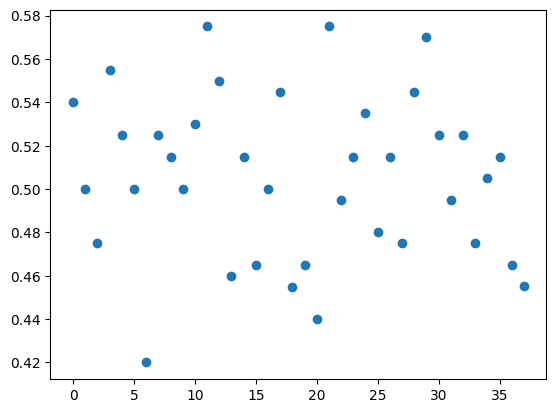

In [64]:
plt.scatter(range(len(vals)), vals)

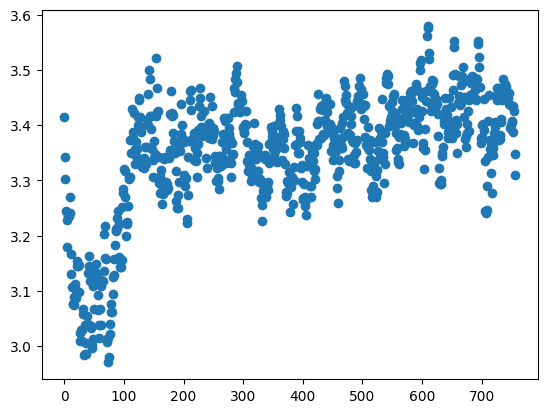

In [65]:
means = [mean(m) for m in ngs]
# means = [mean(m) for m in tmp['rewards']]

interv = 10
mbins = [mean(means[i:i+50]) for i in range(0, len(means), interv)]
plt.scatter(range(len(mbins)), mbins)

In [66]:
mean(means[-200:])

3.4357795902938983

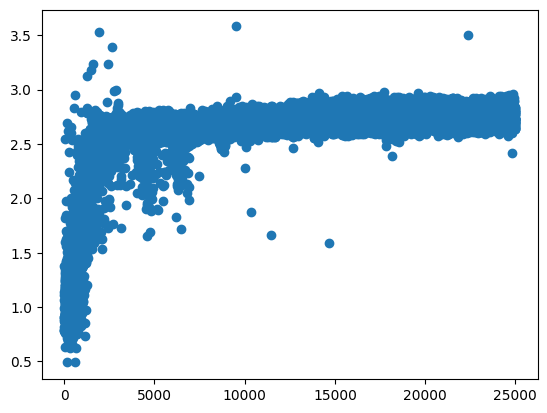

In [113]:
means = [mean(m) for m in tmp['golds']]
plt.scatter(range(len(means)), means)